In [1]:
import json, math, requests
import lkh
from pathlib import Path
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing, solve_tsp_lin_kernighan, solve_tsp_record_to_record
from python_tsp.exact import solve_tsp_dynamic_programming, solve_tsp_branch_and_bound
from python_tsp.distances import tsplib_distance_matrix
from python_tsp.distances import euclidean_distance_matrix

import time, statistics, random

def euclidean_3d(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)

def tour_length(tour, pts):
    return sum(euclidean_3d(pts[tour[i]], pts[tour[i-1]]) for i in range(len(tour)))

# Wrap each method to a callable taking only dist_matrix and returning (perm, length)
def m_2opt(dm):
    # python-tsp's local_search uses 2-opt by default
    return solve_tsp_local_search(dm)

def m_sa(dm):
    return solve_tsp_simulated_annealing(dm)

def m_ls_ps3_seeded_by_sa(dm):
    # pipeline: SA -> LS(ps3); time includes both
    perm_sa, _ = solve_tsp_simulated_annealing(dm)
    return solve_tsp_local_search(dm, x0=perm_sa, perturbation_scheme="ps3")

def m_dp(dm):
    return solve_tsp_dynamic_programming(dm,maxsize=None)

def m_lk(dm):
    return solve_tsp_lin_kernighan(dm)

def m_rtr(dm):
    return solve_tsp_record_to_record(dm, max_iterations=100)

def exact_dp(dm):
    return solve_tsp_dynamic_programming(dm, maxsize=None)

def bb(dm):
    return solve_tsp_branch_and_bound(dm)

def time_cpu(fn, *args, **kwargs):
    """Return (result, cpu_seconds), where result is (perm, length)."""
    t0 = time.process_time()
    result = fn(*args, **kwargs)
    dt = time.process_time() - t0
    return result, dt

def bench_once(name, fn, dm, seed=0):
    random.seed(seed); np.random.seed(seed)
    t0_cpu = time.process_time()
    perm, length = fn(dm)
    cpu_s = time.process_time() - t0_cpu
    return name, cpu_s, length, perm

# Create distance matrix from 3D points without using TSPLIB format
def dm_from_pts(pts):
    pts_array = np.array(pts)
    return euclidean_distance_matrix(pts_array, pts_array)

# Create TSP files using the WORKING LKH method
def create_tsp_with_lkh(filename, name, points):
    """Create TSP file using LKH library - WORKING VERSION"""
    problem = lkh.LKHProblem()
    problem.name = name
    problem.type = "TSP"  
    problem.dimension = len(points)
    problem.edge_weight_type = "EUC_3D"
    
    # The key: use node_coords (dict) not node_coord_section (list)
    node_coords = {}
    for i, (x, y, z) in enumerate(points, 1):
        node_coords[i] = (x, y, z)
    problem.node_coords = node_coords
    
    with open(filename, 'w') as f:
        f.write(problem.render())

In [2]:
# Read marker data from all 3 JSON files
mrk_path = Path("ScannedPoints.mrk.json")
with mrk_path.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)
        
# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts)} points from {mrk_path}")

# Create another dataset that is a randomly downsampled version of pts
pts1_45 = random.sample(pts, len(pts) * 4//5)
pts1_35 = random.sample(pts, len(pts) * 3//5)
pts1_25 = random.sample(pts, len(pts) * 2//5)
pts1_15 = random.sample(pts, len(pts) * 1//5)

# Read marker data from second JSON file
mrk_path2 = Path("ScannedPoints-2.mrk.json")
with mrk_path2.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)

# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts2 = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts2)} points from {mrk_path2}")

# Create another dataset that is a randomly downsampled version of pts2
pts2_45 = random.sample(pts2, len(pts2) * 4//5)
pts2_35 = random.sample(pts2, len(pts2) * 3//5)
pts2_25 = random.sample(pts2, len(pts2) * 2//5)
pts2_15 = random.sample(pts2, len(pts2) * 1//5)

# Read marker data from third JSON file
mrk_path3 = Path("ScannedPoints-3.mrk.json")
with mrk_path3.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)

# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts3 = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts3)} points from {mrk_path3}")

# Create another dataset that is a randomly downsampled version of pts3
pts3_45 = random.sample(pts3, len(pts3) * 4//5)
pts3_35 = random.sample(pts3, len(pts3) * 3//5)
pts3_25 = random.sample(pts3, len(pts3) * 2//5)
pts3_15 = random.sample(pts3, len(pts3) * 1//5)

# Create all TSP files using working LKH method
path_pts = Path("path_pts.tsp")
create_tsp_with_lkh(path_pts, "path_pts", pts)
print(f"Wrote {path_pts}")

path_pts1_45 = Path("path_pts1_45.tsp")
create_tsp_with_lkh(path_pts1_45, "path_pts1_45", pts1_45)
print(f"Wrote {path_pts1_45}")

path_pts1_35 = Path("path_pts1_35.tsp")
create_tsp_with_lkh(path_pts1_35, "path_pts1_35", pts1_35)
print(f"Wrote {path_pts1_35}")

path_pts1_25 = Path("path_pts1_25.tsp")
create_tsp_with_lkh(path_pts1_25, "path_pts1_25", pts1_25)
print(f"Wrote {path_pts1_25}")

path_pts1_15 = Path("path_pts1_15.tsp")
create_tsp_with_lkh(path_pts1_15, "path_pts1_15", pts1_15)
print(f"Wrote {path_pts1_15}")

path_pts2 = Path("path_pts2.tsp")
create_tsp_with_lkh(path_pts2, "path_pts2", pts2)
print(f"Wrote {path_pts2}")

path_pts2_45 = Path("path_pts2_45.tsp")
create_tsp_with_lkh(path_pts2_45, "path_pts2_45", pts2_45)
print(f"Wrote {path_pts2_45}")

path_pts2_35 = Path("path_pts2_35.tsp")
create_tsp_with_lkh(path_pts2_35, "path_pts2_35", pts2_35)
print(f"Wrote {path_pts2_35}")

path_pts2_25 = Path("path_pts2_25.tsp")
create_tsp_with_lkh(path_pts2_25, "path_pts2_25", pts2_25)
print(f"Wrote {path_pts2_25}")

path_pts2_15 = Path("path_pts2_15.tsp")
create_tsp_with_lkh(path_pts2_15, "path_pts2_15", pts2_15)
print(f"Wrote {path_pts2_15}")

path_pts3 = Path("path_pts3.tsp")
create_tsp_with_lkh(path_pts3, "path_pts3", pts3)
print(f"Wrote {path_pts3}")

path_pts3_45 = Path("path_pts3_45.tsp")
create_tsp_with_lkh(path_pts3_45, "path_pts3_45", pts3_45)
print(f"Wrote {path_pts3_45}")

path_pts3_35 = Path("path_pts3_35.tsp")
create_tsp_with_lkh(path_pts3_35, "path_pts3_35", pts3_35)
print(f"Wrote {path_pts3_35}")  

path_pts3_25 = Path("path_pts3_25.tsp")
create_tsp_with_lkh(path_pts3_25, "path_pts3_25", pts3_25)
print(f"Wrote {path_pts3_25}")

path_pts3_15 = Path("path_pts3_15.tsp")
create_tsp_with_lkh(path_pts3_15, "path_pts3_15", pts3_15)
print(f"Wrote {path_pts3_15}")

dist1_matrix = tsplib_distance_matrix("path_pts.tsp")
dist1_matrix45 = tsplib_distance_matrix("path_pts1_45.tsp")
dist1_matrix35 = tsplib_distance_matrix("path_pts1_35.tsp")
dist1_matrix25 = tsplib_distance_matrix("path_pts1_25.tsp")
dist1_matrix15 = tsplib_distance_matrix("path_pts1_15.tsp")
dist2_matrix = tsplib_distance_matrix("path_pts2.tsp")
dist2_matrix45 = tsplib_distance_matrix("path_pts2_45.tsp")
dist2_matrix35 = tsplib_distance_matrix("path_pts2_35.tsp")
dist2_matrix25 = tsplib_distance_matrix("path_pts2_25.tsp")
dist2_matrix15 = tsplib_distance_matrix("path_pts2_15.tsp")
dist3_matrix = tsplib_distance_matrix("path_pts3.tsp")
dist3_matrix45 = tsplib_distance_matrix("path_pts3_45.tsp")
dist3_matrix35 = tsplib_distance_matrix("path_pts3_35.tsp")
dist3_matrix25 = tsplib_distance_matrix("path_pts3_25.tsp")
dist3_matrix15 = tsplib_distance_matrix("path_pts3_15.tsp")

Successfully loaded marker data
Loaded 357 points from ScannedPoints.mrk.json
Successfully loaded marker data
Loaded 374 points from ScannedPoints-2.mrk.json
Successfully loaded marker data
Loaded 257 points from ScannedPoints-3.mrk.json
Wrote path_pts.tsp
Wrote path_pts1_45.tsp
Wrote path_pts1_35.tsp
Wrote path_pts1_25.tsp
Wrote path_pts1_15.tsp
Wrote path_pts2.tsp
Wrote path_pts2_45.tsp
Wrote path_pts2_35.tsp
Wrote path_pts2_25.tsp
Wrote path_pts2_15.tsp
Wrote path_pts3.tsp
Wrote path_pts3_45.tsp
Wrote path_pts3_35.tsp
Wrote path_pts3_25.tsp
Wrote path_pts3_15.tsp


In [3]:
# ---- choose methods -------------------------------------------------------
methods = [
    ("2-opt (local search)",   m_2opt),
    ("Simulated annealing",    m_sa),
    ("SA → LS (ps3)",          m_ls_ps3_seeded_by_sa),
    ("Lin–Kernighan",          m_lk),  
    #("Branch & Bound",       bb),
]

# Define datasets with their info
datasets = [
    ("Dataset 1", dist1_matrix, len(pts), "path_pts.tsp"),
    ("Dataset 1 4/5", dist1_matrix45, len(pts1_45), "path_pts1_45.tsp"),
    ("Dataset 1 3/5", dist1_matrix35, len(pts1_35), "path_pts1_35.tsp"),
    ("Dataset 1 2/5", dist1_matrix25, len(pts1_25), "path_pts1_25.tsp"),
    ("Dataset 1 1/5", dist1_matrix15, len(pts1_15), "path_pts1_15.tsp"),
    ("Dataset 2", dist2_matrix, len(pts2), "path_pts2.tsp"),
    ("Dataset 2 4/5", dist2_matrix45, len(pts2_45), "path_pts2_45.tsp"),
    ("Dataset 2 3/5", dist2_matrix35, len(pts2_35), "path_pts2_35.tsp"),
    ("Dataset 2 2/5", dist2_matrix25, len(pts2_25), "path_pts2_25.tsp"),
    ("Dataset 2 1/5", dist2_matrix15, len(pts2_15), "path_pts2_15.tsp"),
    ("Dataset 3", dist3_matrix, len(pts3), "path_pts3.tsp"),
    ("Dataset 3 4/5", dist3_matrix45, len(pts3_45), "path_pts3_45.tsp"),  
    ("Dataset 3 3/5", dist3_matrix35, len(pts3_35), "path_pts3_35.tsp"),  
    ("Dataset 3 2/5", dist3_matrix25, len(pts3_25), "path_pts3_25.tsp"),  
    ("Dataset 3 1/5", dist3_matrix15, len(pts3_15), "path_pts3_15.tsp"),  
]

# Store results for comparison
all_results = {}  # {dataset_name: {method_name: (cpu_time, length)}}

# Run each method on each dataset
for dataset_name, dm, n_points, filename in datasets:
    print(f"\nStarting {dataset_name} (n={n_points})")
    all_results[dataset_name] = {}
    
    for method_name, method_fn in methods:
        print(f"  Running {method_name}...", end='', flush=True)
        try:
            _, cpu_s, length, perm = bench_once(method_name, method_fn, dm, seed=123)
            all_results[dataset_name][method_name] = (cpu_s, length)
            print(f" done (CPU: {cpu_s:.2f}s, length: {length:.1f})")
        except Exception as e:
            print(f" failed ({str(e)})")
            all_results[dataset_name][method_name] = (float('inf'), float('inf'))


Starting Dataset 1 (n=357)
  Running 2-opt (local search)... done (CPU: 7.45s, length: 707.0)
  Running Simulated annealing... done (CPU: 7.45s, length: 707.0)
  Running Simulated annealing... done (CPU: 10.71s, length: 723.0)
  Running SA → LS (ps3)... done (CPU: 10.71s, length: 723.0)
  Running SA → LS (ps3)... done (CPU: 16.22s, length: 703.0)
  Running Lin–Kernighan... done (CPU: 16.22s, length: 703.0)
  Running Lin–Kernighan... done (CPU: 0.28s, length: 695.0)

Starting Dataset 1 4/5 (n=285)
  Running 2-opt (local search)... done (CPU: 0.28s, length: 695.0)

Starting Dataset 1 4/5 (n=285)
  Running 2-opt (local search)... done (CPU: 3.93s, length: 579.0)
  Running Simulated annealing... done (CPU: 3.93s, length: 579.0)
  Running Simulated annealing... done (CPU: 8.57s, length: 586.0)
  Running SA → LS (ps3)... done (CPU: 8.57s, length: 586.0)
  Running SA → LS (ps3)... done (CPU: 11.19s, length: 574.0)
  Running Lin–Kernighan... done (CPU: 11.19s, length: 574.0)
  Running Lin–Ker

In [6]:
# ================ BENCHMARK RESULTS ================
print("\nBENCHMARK RESULTS")
print("="*70)

# 1. Progress report for each dataset
for dataset_name, _, n_points, _ in datasets:
    print(f"\n--- {dataset_name} (n={n_points}) ---")
    for method_name, _ in methods:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            print(f"{method_name:22s}  CPU {cpu_time:8.4f} s   length {length:.3f}")

# 2. Results table by method (CPU time)
print("\n" + "="*70)
print("COMPARISON ANALYSIS")
print("="*70)

print("\n1. RESULTS BY METHOD (CPU Time)")
print("-" * 70)
header = f"{'Method':<22} {'Dataset 1':<15} {'Dataset 2':<15} {'Dataset 3':<15}"
print(header)
print("-" * 70)

for method_name, _ in methods:
    line = f"{method_name:<22} "
    for dataset_name, _, _, _ in datasets:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            if cpu_time == float('inf'):
                line += f"{'FAILED':<15} "
            else:
                line += f"{cpu_time:8.4f}s     "
        else:
            line += f"{'N/A':<15} "
    print(line)

# 3. Tour lengths comparison
print(f"\n2. TOUR LENGTHS COMPARISON")
print("-" * 70)
header = f"{'Method':<22} {'Dataset 1':<15} {'Dataset 2':<15} {'Dataset 3':<15}"
print(header)
print("-" * 70)

for method_name, _ in methods:
    line = f"{method_name:<22} "
    for dataset_name, _, _, _ in datasets:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            if length == float('inf'):
                line += f"{'FAILED':<15} "
            else:
                line += f"{length:10.1f}     "
        else:
            line += f"{'N/A':<15} "
    print(line)

# 4. Summary statistics
print("\n3. SUMMARY STATISTICS")
print("-" * 70)
for dataset_name, _, n_points, _ in datasets:
    print(f"\n{dataset_name} (n={n_points:3d}):")
    
    # Best tour length
    valid_results = [(method, length) for method, (cpu_time, length) in all_results[dataset_name].items() 
                     if length != float('inf')]
    if valid_results:
        best_method, best_length = min(valid_results, key=lambda x: x[1])
        print(f"Best tour length:  {best_method:<22} length={best_length:.1f}")
    
    # Fastest method
    valid_results = [(method, cpu_time) for method, (cpu_time, length) in all_results[dataset_name].items() 
                     if cpu_time != float('inf')]
    if valid_results:
        fastest_method, fastest_time = min(valid_results, key=lambda x: x[1])
        print(f"Fastest solution: {fastest_method:<22} time={fastest_time:.4f}s")


BENCHMARK RESULTS

--- Dataset 1 (n=357) ---
2-opt (local search)    CPU   7.4504 s   length 707.000
Simulated annealing     CPU  10.7075 s   length 723.000
SA → LS (ps3)           CPU  16.2222 s   length 703.000
Lin–Kernighan           CPU   0.2791 s   length 695.000

--- Dataset 1 4/5 (n=285) ---
2-opt (local search)    CPU   3.9274 s   length 579.000
Simulated annealing     CPU   8.5687 s   length 586.000
SA → LS (ps3)           CPU  11.1854 s   length 574.000
Lin–Kernighan           CPU   0.1529 s   length 613.000

--- Dataset 1 3/5 (n=214) ---
2-opt (local search)    CPU   1.4432 s   length 482.000
Simulated annealing     CPU   3.3051 s   length 483.000
SA → LS (ps3)           CPU   5.4567 s   length 464.000
Lin–Kernighan           CPU   0.0976 s   length 462.000

--- Dataset 1 2/5 (n=142) ---
2-opt (local search)    CPU   0.5270 s   length 357.000
Simulated annealing     CPU   1.8213 s   length 359.000
SA → LS (ps3)           CPU   2.5261 s   length 339.000
Lin–Kernighan        

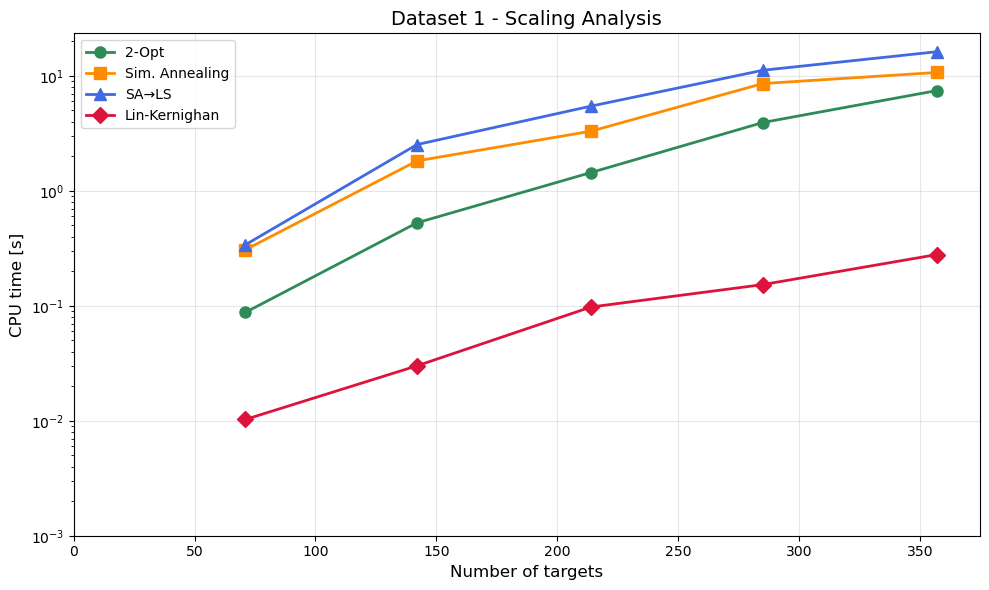

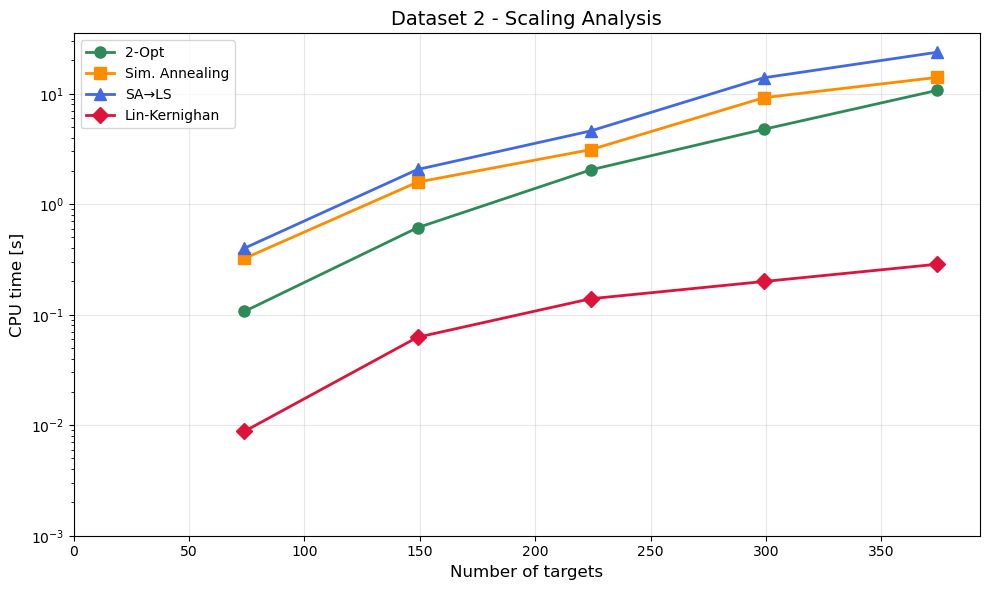

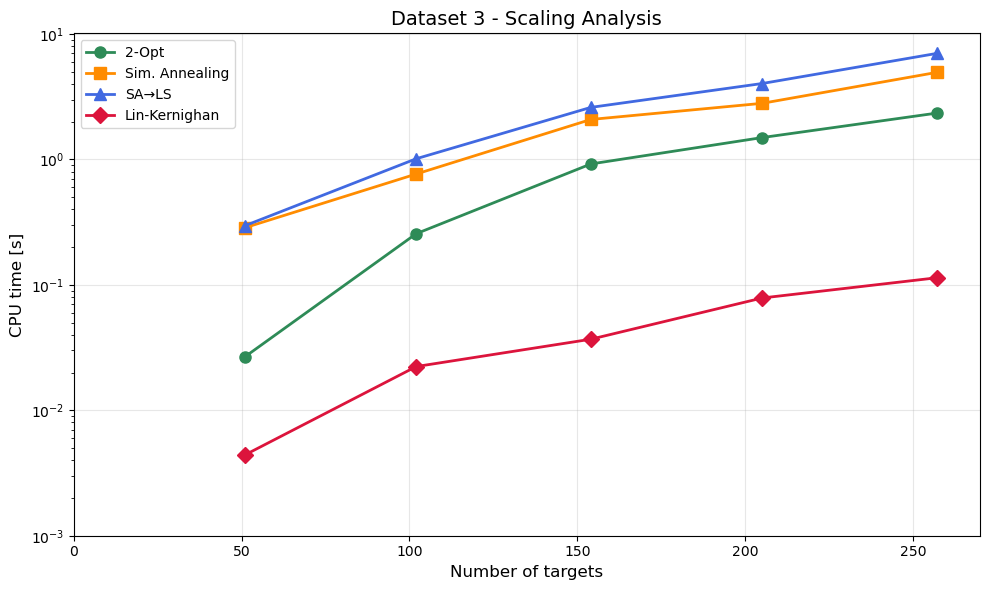


Scaling Analysis Summary:

Dataset 1:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
------------------------------------------------------------
357     7.450       10.707      16.222      0.279       
285     3.927       8.569       11.185      0.153       
214     1.443       3.305       5.457       0.098       
142     0.527       1.821       2.526       0.030       
71      0.088       0.307       0.339       0.010       

Dataset 2:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
------------------------------------------------------------
374     10.704      14.039      23.703      0.286       
299     4.762       9.199       13.937      0.200       
224     2.044       3.115       4.602       0.139       
149     0.613       1.585       2.062       0.063       
74      0.107       0.323       0.400       0.009       

Dataset 3:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
------------------------------------------------------------
2

In [7]:
# Create scaling plots using existing data (like the attached image)
import matplotlib.pyplot as plt
import numpy as np

# Define the scaling data structure based on existing results
dataset_groups = [
    # Dataset 1 group
    [("Dataset 1", len(pts)), ("Dataset 1 4/5", len(pts1_45)), ("Dataset 1 3/5", len(pts1_35)), 
     ("Dataset 1 2/5", len(pts1_25)), ("Dataset 1 1/5", len(pts1_15))],
    # Dataset 2 group  
    [("Dataset 2", len(pts2)), ("Dataset 2 4/5", len(pts2_45)), ("Dataset 2 3/5", len(pts2_35)),
     ("Dataset 2 2/5", len(pts2_25)), ("Dataset 2 1/5", len(pts2_15))],
    # Dataset 3 group
    [("Dataset 3", len(pts3)), ("Dataset 3 4/5", len(pts3_45)), ("Dataset 3 3/5", len(pts3_35)),
     ("Dataset 3 2/5", len(pts3_25)), ("Dataset 3 1/5", len(pts3_15))]
]

method_names = [name for name, _ in methods]
colors = ['#2E8B57', '#FF8C00', '#4169E1', '#DC143C']  # Green, Orange, Blue, Red
markers = ['o', 's', '^', 'D']
method_labels = ['2-Opt', 'Sim. Annealing', 'SA→LS', 'Lin-Kernighan']

# Create 3 separate plots for the 3 datasets
for dataset_idx, dataset_group in enumerate(dataset_groups):
    plt.figure(figsize=(10, 6))
    
    for method_idx, (method_name, _) in enumerate(methods):
        n_points = []
        cpu_times = []
        
        # Extract data for this method across all sizes of this dataset
        for dataset_name, n_pts in dataset_group:
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                cpu_time, _ = all_results[dataset_name][method_name]
                if cpu_time != float('inf') and cpu_time > 0:
                    n_points.append(n_pts)
                    cpu_times.append(cpu_time)
        
        if n_points and cpu_times:
            plt.semilogy(n_points, cpu_times, 
                        color=colors[method_idx], 
                        marker=markers[method_idx], 
                        markersize=8,
                        linewidth=2,
                        label=method_labels[method_idx])
    
    plt.xlabel('Number of targets', fontsize=12)
    plt.ylabel('CPU time [s]', fontsize=12)
    plt.title(f'Dataset {dataset_idx + 1} - Scaling Analysis', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Set x-axis from 0 to original dataset size
    original_size = dataset_group[0][1]  # First entry is full size
    plt.xlim(0, original_size * 1.05)  # Add 5% padding
    plt.ylim(0.001, None)  # Let y-axis auto-scale upper limit
    
    plt.tight_layout()
    plt.show()

# Print summary of scaling data
print("\nScaling Analysis Summary:")
print("=" * 80)
for dataset_idx, dataset_group in enumerate(dataset_groups):
    print(f"\nDataset {dataset_idx + 1}:")
    print(f"{'Size':<8} {'2-Opt':<12} {'Sim.Ann.':<12} {'SA→LS':<12} {'Lin-Kern.':<12}")
    print("-" * 60)
    
    for dataset_name, n_pts in dataset_group:
        line = f"{n_pts:<8}"
        for method_name, _ in methods:
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                cpu_time, _ = all_results[dataset_name][method_name]
                if cpu_time != float('inf'):
                    line += f"{cpu_time:<12.3f}"
                else:
                    line += f"{'FAILED':<12}"
            else:
                line += f"{'N/A':<12}"
        print(line)

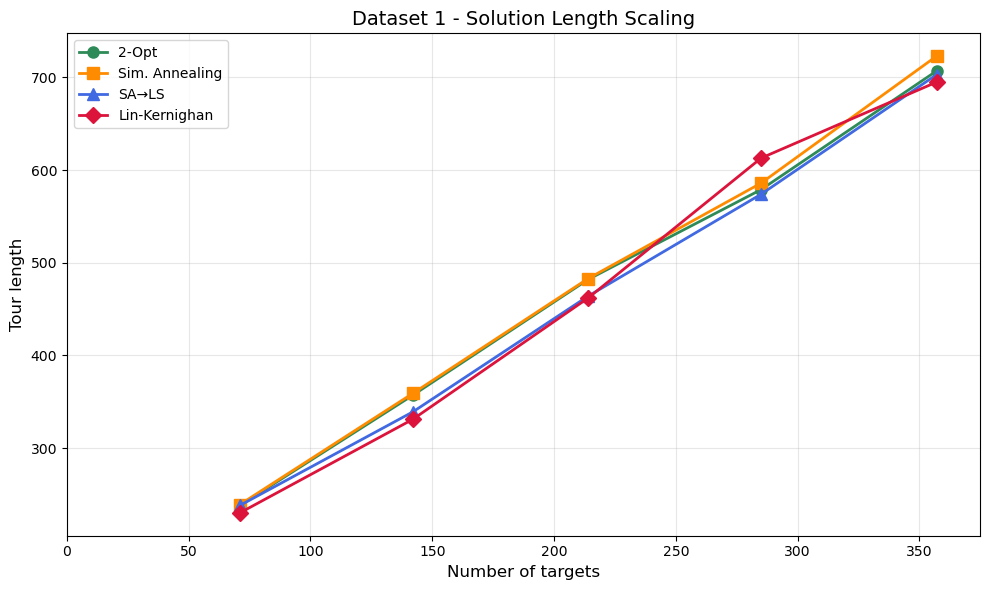

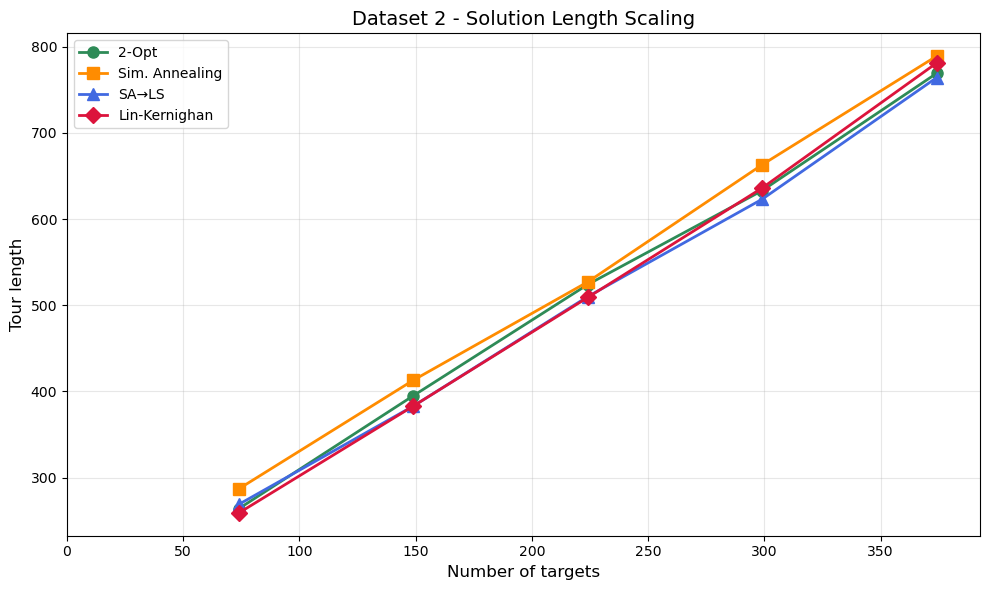

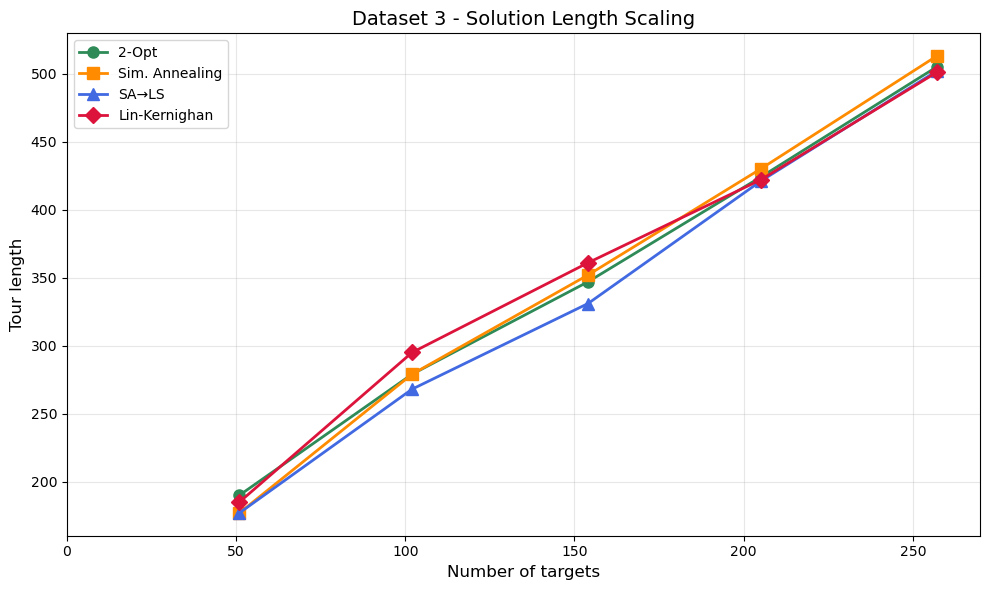


Solution Length Scaling Summary:

Dataset 1:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
------------------------------------------------------------
357     707.0       723.0       703.0       695.0       
285     579.0       586.0       574.0       613.0       
214     482.0       483.0       464.0       462.0       
142     357.0       359.0       339.0       331.0       
71      238.0       239.0       238.0       230.0       

Dataset 2:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
------------------------------------------------------------
374     769.0       789.0       764.0       781.0       
299     633.0       663.0       623.0       636.0       
224     524.0       527.0       510.0       509.0       
149     395.0       413.0       383.0       383.0       
74      264.0       287.0       269.0       259.0       

Dataset 3:
Size     2-Opt        Sim.Ann.     SA→LS        Lin-Kern.   
-------------------------------------------------------

In [8]:
# Plot solution length scaling for each method and dataset (like the CPU time plots)
import matplotlib.pyplot as plt
import numpy as np

# Define the scaling data structure based on existing results (reuse from above)
dataset_groups = [
    [("Dataset 1", len(pts)), ("Dataset 1 4/5", len(pts1_45)), ("Dataset 1 3/5", len(pts1_35)), ("Dataset 1 2/5", len(pts1_25)), ("Dataset 1 1/5", len(pts1_15))],
    [("Dataset 2", len(pts2)), ("Dataset 2 4/5", len(pts2_45)), ("Dataset 2 3/5", len(pts2_35)), ("Dataset 2 2/5", len(pts2_25)), ("Dataset 2 1/5", len(pts2_15))],
    [("Dataset 3", len(pts3)), ("Dataset 3 4/5", len(pts3_45)), ("Dataset 3 3/5", len(pts3_35)), ("Dataset 3 2/5", len(pts3_25)), ("Dataset 3 1/5", len(pts3_15))]
]

method_names = [name for name, _ in methods]
colors = ['#2E8B57', '#FF8C00', '#4169E1', '#DC143C']  # Green, Orange, Blue, Red
markers = ['o', 's', '^', 'D']
method_labels = ['2-Opt', 'Sim. Annealing', 'SA→LS', 'Lin-Kernighan']

# Create 3 separate plots for the 3 datasets (Y axis: solution length)
for dataset_idx, dataset_group in enumerate(dataset_groups):
    plt.figure(figsize=(10, 6))
    
    for method_idx, (method_name, _) in enumerate(methods):
        n_points = []
        tour_lengths = []
        
        # Extract data for this method across all sizes of this dataset
        for dataset_name, n_pts in dataset_group:
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                _, length = all_results[dataset_name][method_name]
                if length != float('inf') and length > 0:
                    n_points.append(n_pts)
                    tour_lengths.append(length)
        
        if n_points and tour_lengths:
            plt.plot(n_points, tour_lengths, 
                     color=colors[method_idx], 
                     marker=markers[method_idx], 
                     markersize=8,
                     linewidth=2,
                     label=method_labels[method_idx])
    
    plt.xlabel('Number of targets', fontsize=12)
    plt.ylabel('Tour length', fontsize=12)
    plt.title(f'Dataset {dataset_idx + 1} - Solution Length Scaling', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Set x-axis from 0 to original dataset size
    original_size = dataset_group[0][1]  # First entry is full size
    plt.xlim(0, original_size * 1.05)  # Add 5% padding
    plt.tight_layout()
    plt.show()

# Print summary of solution lengths
print("\nSolution Length Scaling Summary:")
print("=" * 80)
for dataset_idx, dataset_group in enumerate(dataset_groups):
    print(f"\nDataset {dataset_idx + 1}:")
    print(f"{'Size':<8} {'2-Opt':<12} {'Sim.Ann.':<12} {'SA→LS':<12} {'Lin-Kern.':<12}")
    print("-" * 60)
    
    for dataset_name, n_pts in dataset_group:
        line = f"{n_pts:<8}"
        for method_name, _ in methods:
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                _, length = all_results[dataset_name][method_name]
                if length != float('inf'):
                    line += f"{length:<12.1f}"
                else:
                    line += f"{'FAILED':<12}"
            else:
                line += f"{'N/A':<12}"
        print(line)

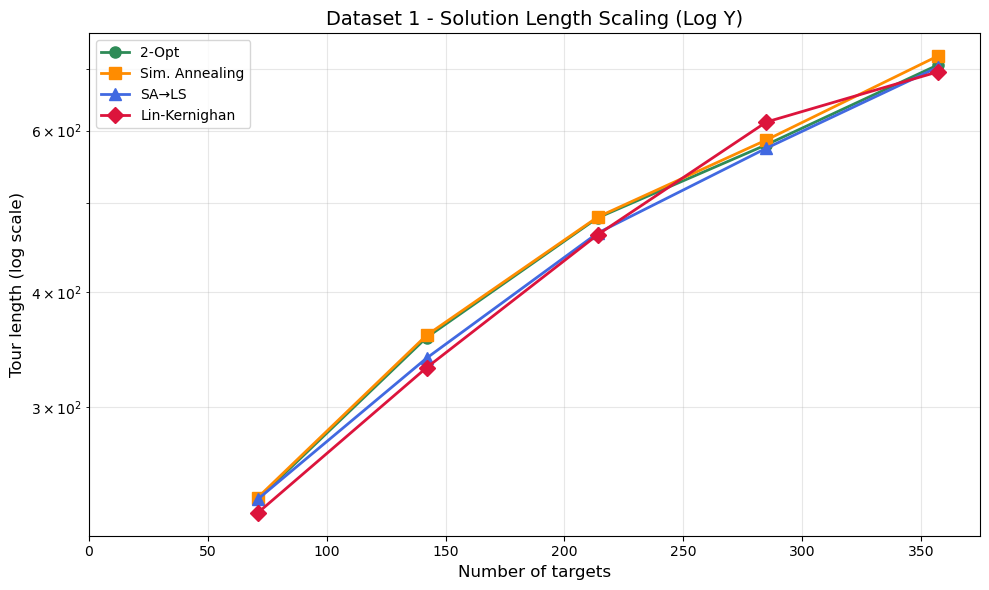

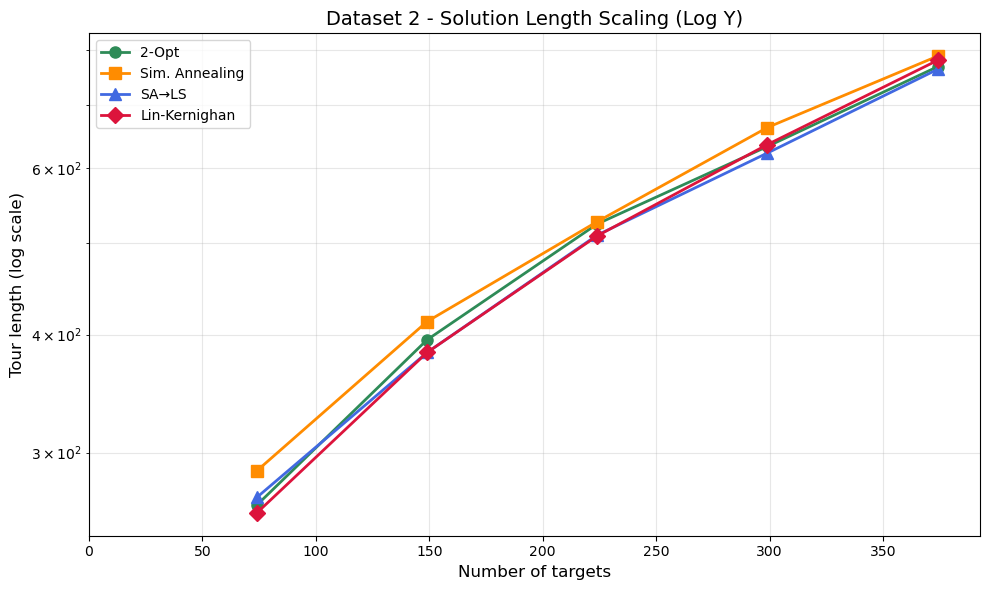

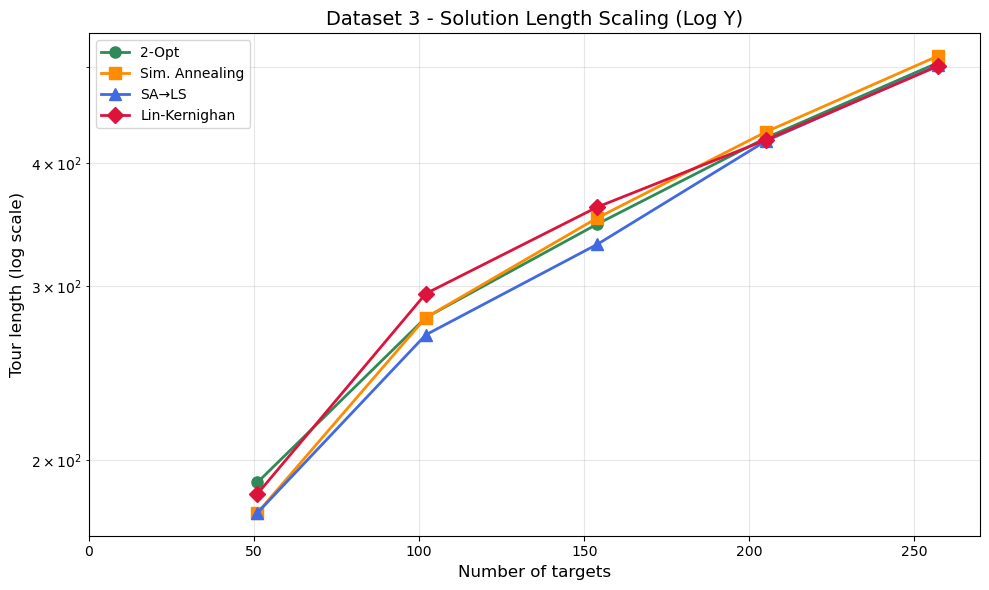

In [9]:
# Plot solution length scaling for each method and dataset (log Y axis)
import matplotlib.pyplot as plt
import numpy as np

# Define the scaling data structure based on existing results (reuse from above)
dataset_groups = [
    [("Dataset 1", len(pts)), ("Dataset 1 4/5", len(pts1_45)), ("Dataset 1 3/5", len(pts1_35)), ("Dataset 1 2/5", len(pts1_25)), ("Dataset 1 1/5", len(pts1_15))],
    [("Dataset 2", len(pts2)), ("Dataset 2 4/5", len(pts2_45)), ("Dataset 2 3/5", len(pts2_35)), ("Dataset 2 2/5", len(pts2_25)), ("Dataset 2 1/5", len(pts2_15))],
    [("Dataset 3", len(pts3)), ("Dataset 3 4/5", len(pts3_45)), ("Dataset 3 3/5", len(pts3_35)), ("Dataset 3 2/5", len(pts3_25)), ("Dataset 3 1/5", len(pts3_15))]
]

method_names = [name for name, _ in methods]
colors = ['#2E8B57', '#FF8C00', '#4169E1', '#DC143C']  # Green, Orange, Blue, Red
markers = ['o', 's', '^', 'D']
method_labels = ['2-Opt', 'Sim. Annealing', 'SA→LS', 'Lin-Kernighan']

# Create 3 separate plots for the 3 datasets (Y axis: solution length, log scale)
for dataset_idx, dataset_group in enumerate(dataset_groups):
    plt.figure(figsize=(10, 6))
    
    for method_idx, (method_name, _) in enumerate(methods):
        n_points = []
        tour_lengths = []
        
        # Extract data for this method across all sizes of this dataset
        for dataset_name, n_pts in dataset_group:
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                _, length = all_results[dataset_name][method_name]
                if length != float('inf') and length > 0:
                    n_points.append(n_pts)
                    tour_lengths.append(length)
        
        if n_points and tour_lengths:
            plt.semilogy(n_points, tour_lengths, 
                         color=colors[method_idx], 
                         marker=markers[method_idx], 
                         markersize=8,
                         linewidth=2,
                         label=method_labels[method_idx])
    
    plt.xlabel('Number of targets', fontsize=12)
    plt.ylabel('Tour length (log scale)', fontsize=12)
    plt.title(f'Dataset {dataset_idx + 1} - Solution Length Scaling (Log Y)', fontsize=14)
    plt.grid(True, alpha=0.3, which='both')
    plt.legend(fontsize=10)
    
    # Set x-axis from 0 to original dataset size
    original_size = dataset_group[0][1]  # First entry is full size
    plt.xlim(0, original_size * 1.05)  # Add 5% padding
    plt.tight_layout()
    plt.show()

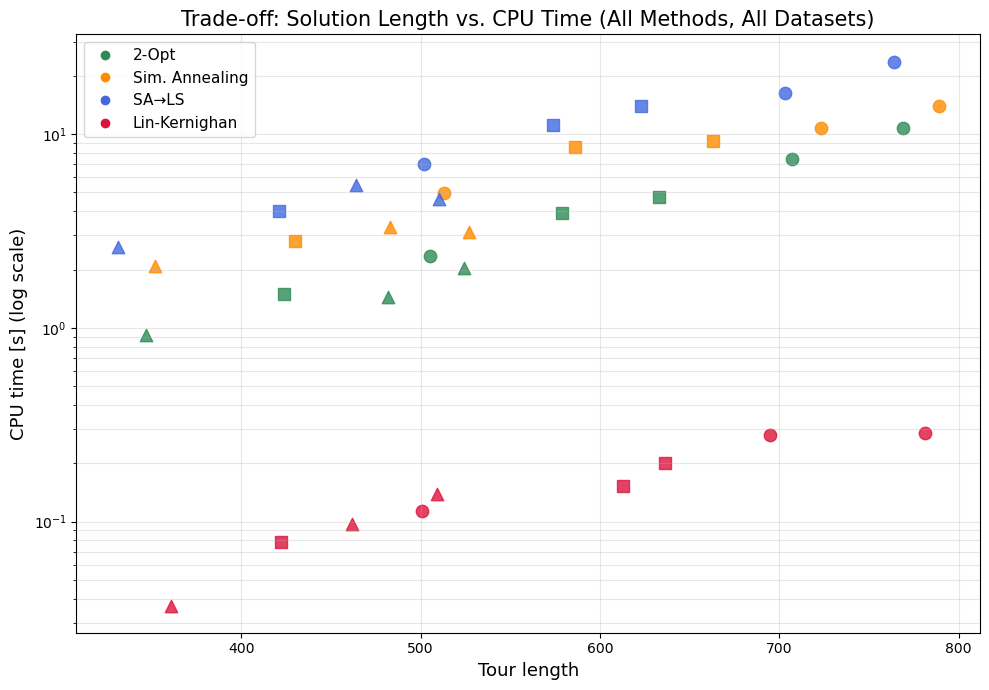

Each point shows a method/dataset/size. Lower left = better (shorter tour, less time). Color = method.


In [ ]:
# Scatter plot: CPU time (Y, log scale) vs. solution length (X) for all methods and dataset sizes
# Each point: (solution length, CPU time) for a method/dataset/size; color = method, marker = dataset
import matplotlib.pyplot as plt
import numpy as np

method_names = [name for name, _ in methods]
colors = ['#2E8B57', '#FF8C00', '#4169E1', '#DC143C']  # Green, Orange, Blue, Red
markers = ['o', 's', '^']  # One per dataset
method_labels = ['2-Opt', 'Sim. Annealing', 'SA→LS', 'Lin-Kernighan']
dataset_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']

# For each dataset, collect all (length, cpu_time, method_idx, dataset_idx)
points = []
for dataset_idx, dataset_label in enumerate(dataset_labels):
    for method_idx, (method_name, _) in enumerate(methods):
        for frac, marker in zip(['', ' 4/5', ' 3/5', ' 2/5', ' 1/5'], markers):
            dataset_name = dataset_label + frac
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                cpu_time, length = all_results[dataset_name][method_name]
                if cpu_time != float('inf') and cpu_time > 0 and length != float('inf') and length > 0:
                    points.append({
                        'length': length,
                        'cpu_time': cpu_time,
                        'method_idx': method_idx,
                        'dataset_idx': dataset_idx,
                        'marker': marker,
                        'method_label': method_labels[method_idx],
                        'dataset_label': dataset_label + frac
                    })

plt.figure(figsize=(10, 7))
for method_idx, method_label in enumerate(method_labels):
    for dataset_idx, marker in enumerate(markers):
        xs = [p['length'] for p in points if p['method_idx'] == method_idx and p['marker'] == marker]
        ys = [p['cpu_time'] for p in points if p['method_idx'] == method_idx and p['marker'] == marker]
        if xs and ys:
            plt.scatter(xs, ys, color=colors[method_idx], marker=marker, s=80, label=f"{method_label} ({dataset_labels[dataset_idx]})" if dataset_idx==0 else None, alpha=0.8)

plt.yscale('log')
plt.xlabel('Tour length', fontsize=13)
plt.ylabel('CPU time [s] (log scale)', fontsize=13)
plt.title('Trade-off: Solution Length vs. CPU Time (All Methods, All Datasets)', fontsize=15)
# Custom legend: one per method
handles = []
for method_idx, method_label in enumerate(method_labels):
    handles.append(plt.Line2D([], [], color=colors[method_idx], marker='o', linestyle='', label=method_label))
plt.legend(handles=handles, fontsize=11, loc='best')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print("Each point shows a method/dataset/size. Lower left = better (shorter tour, less time). Color = method.")

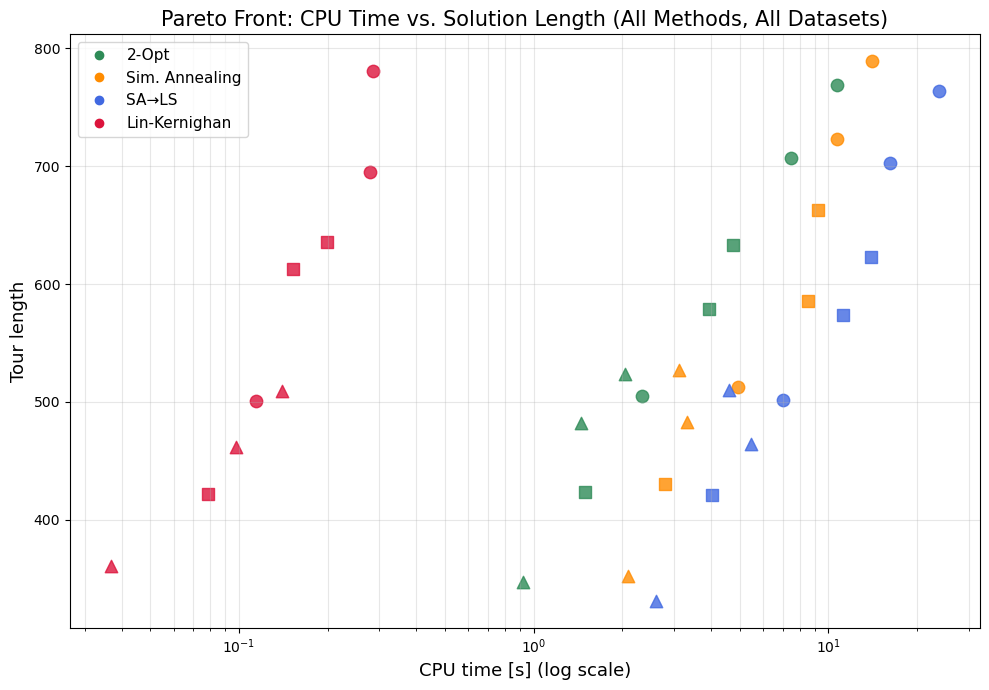

Each point shows a method/dataset/size. Lower left = better (less time, shorter tour). Color = method.


In [12]:
# Pareto plot: CPU time (X, log scale) vs. tour length (Y) for all methods and dataset sizes
# Each point: (CPU time, tour length) for a method/dataset/size; color = method, marker = dataset
import matplotlib.pyplot as plt
import numpy as np

method_names = [name for name, _ in methods]
colors = ['#2E8B57', '#FF8C00', '#4169E1', '#DC143C']  # Green, Orange, Blue, Red
markers = ['o', 's', '^']  # One per dataset
method_labels = ['2-Opt', 'Sim. Annealing', 'SA→LS', 'Lin-Kernighan']
dataset_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']

# For each dataset, collect all (cpu_time, length, method_idx, dataset_idx)
points = []
for dataset_idx, dataset_label in enumerate(dataset_labels):
    for method_idx, (method_name, _) in enumerate(methods):
        for frac, marker in zip(['', ' 4/5', ' 3/5', ' 2/5', ' 1/5'], markers):
            dataset_name = dataset_label + frac
            if dataset_name in all_results and method_name in all_results[dataset_name]:
                cpu_time, length = all_results[dataset_name][method_name]
                if cpu_time != float('inf') and cpu_time > 0 and length != float('inf') and length > 0:
                    points.append({
                        'cpu_time': cpu_time,
                        'length': length,
                        'method_idx': method_idx,
                        'dataset_idx': dataset_idx,
                        'marker': marker,
                        'method_label': method_labels[method_idx],
                        'dataset_label': dataset_label + frac
                    })

plt.figure(figsize=(10, 7))
for method_idx, method_label in enumerate(method_labels):
    for dataset_idx, marker in enumerate(markers):
        xs = [p['cpu_time'] for p in points if p['method_idx'] == method_idx and p['marker'] == marker]
        ys = [p['length'] for p in points if p['method_idx'] == method_idx and p['marker'] == marker]
        if xs and ys:
            plt.scatter(xs, ys, color=colors[method_idx], marker=marker, s=80, label=f"{method_label} ({dataset_labels[dataset_idx]})" if dataset_idx==0 else None, alpha=0.8)

plt.xscale('log')
plt.xlabel('CPU time [s] (log scale)', fontsize=13)
plt.ylabel('Tour length', fontsize=13)
plt.title('Pareto Front: CPU Time vs. Solution Length (All Methods, All Datasets)', fontsize=15)
# Custom legend: one per method
handles = []
for method_idx, method_label in enumerate(method_labels):
    handles.append(plt.Line2D([], [], color=colors[method_idx], marker='o', linestyle='', label=method_label))
plt.legend(handles=handles, fontsize=11, loc='best')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

print("Each point shows a method/dataset/size. Lower left = better (less time, shorter tour). Color = method.")